# Layout Plotting

In [1]:
# Useful for debugging
%load_ext autoreload
%autoreload 2

In [2]:
import os
import numpy as np

from impact import Impact

from impact.parsers import parse_impact_input
from impact.plotting import layout_plot
from impact.fieldmaps import ele_field, lattice_field

from bokeh.plotting import output_notebook
from bokeh.plotting import show
output_notebook(hide_banner=True)

import matplotlib.pyplot as plt
from ipywidgets import interact
%config InlineBackend.figure_format = 'retina'

In [3]:
infile = 'templates/lcls_injector/ImpactT.in'

## matplotlib plotting from the Impact object

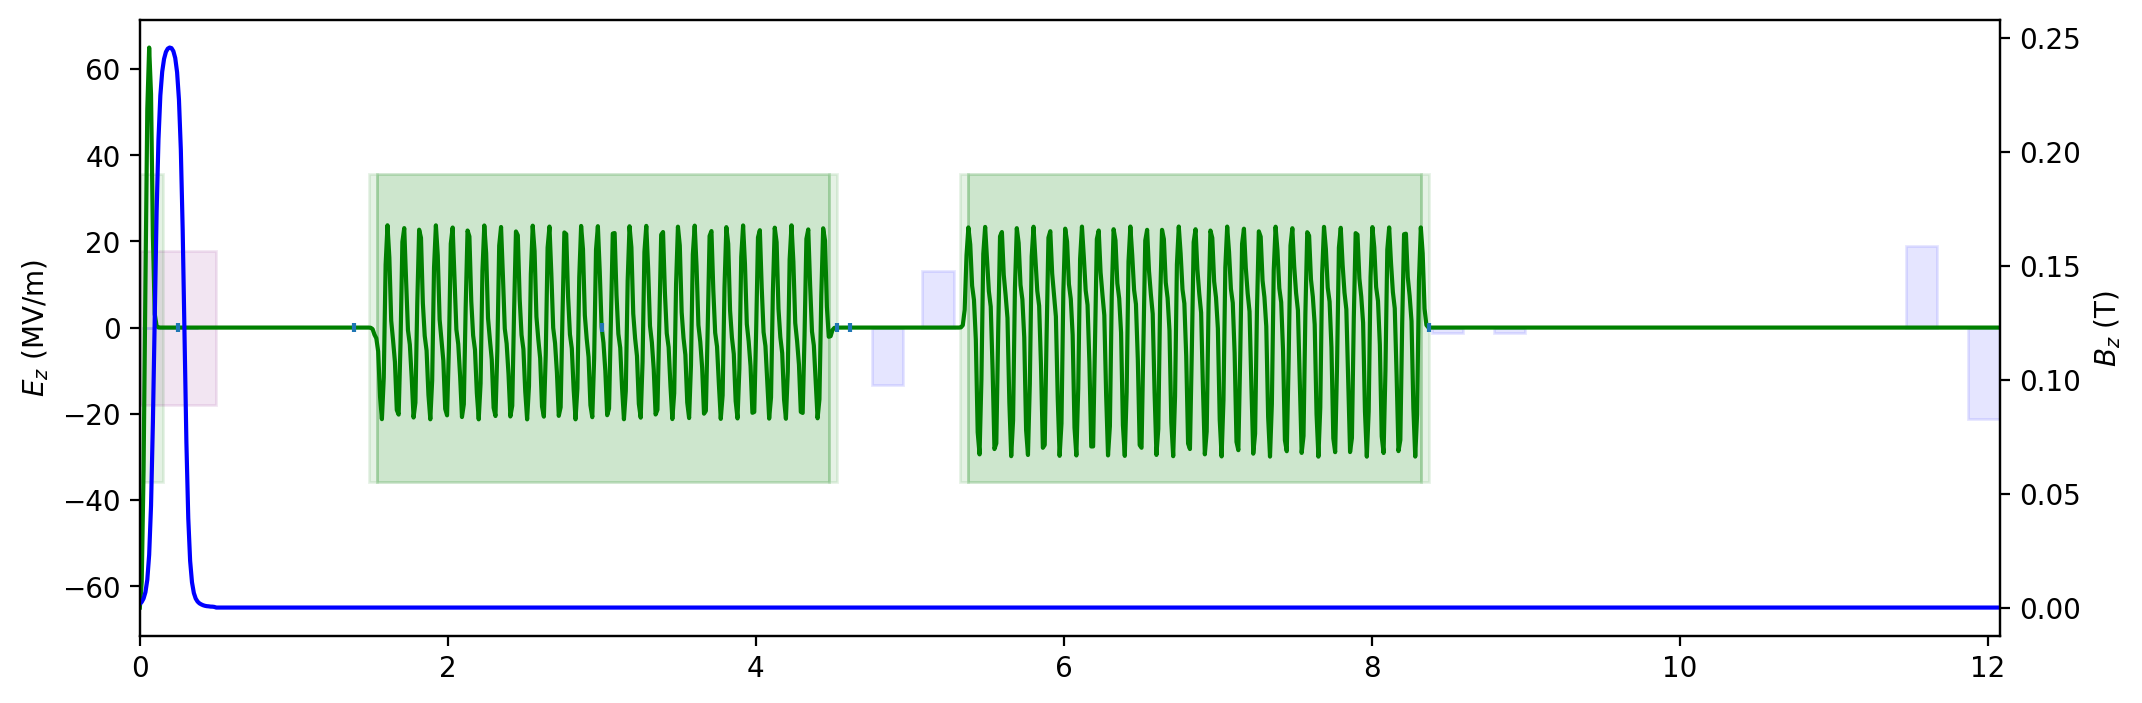

In [4]:
I = Impact(infile)
I.plot(figsize=(12,4))

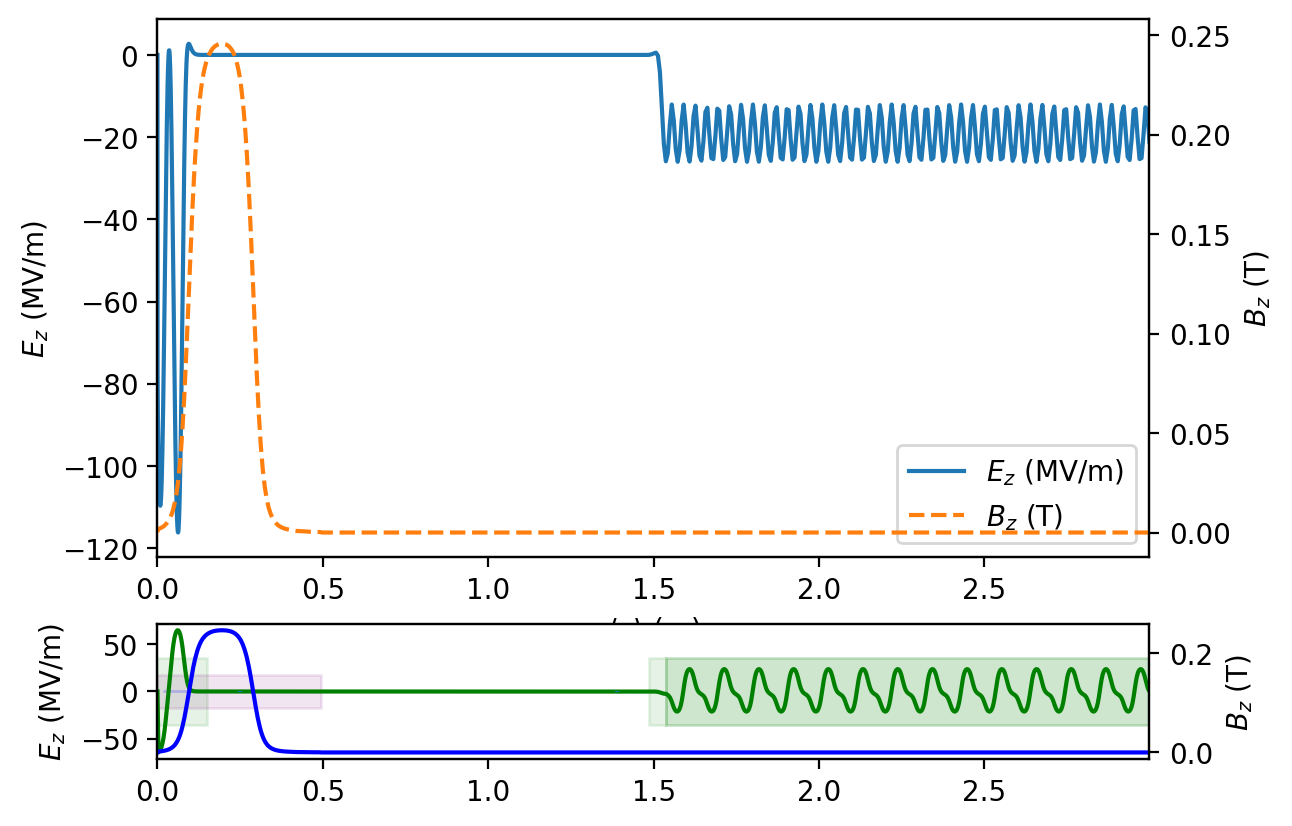

In [5]:
# Track 1 particle
I.track1()

# These are the fields seen by the bunch centroid
I.plot('Ez', y2='Bz')

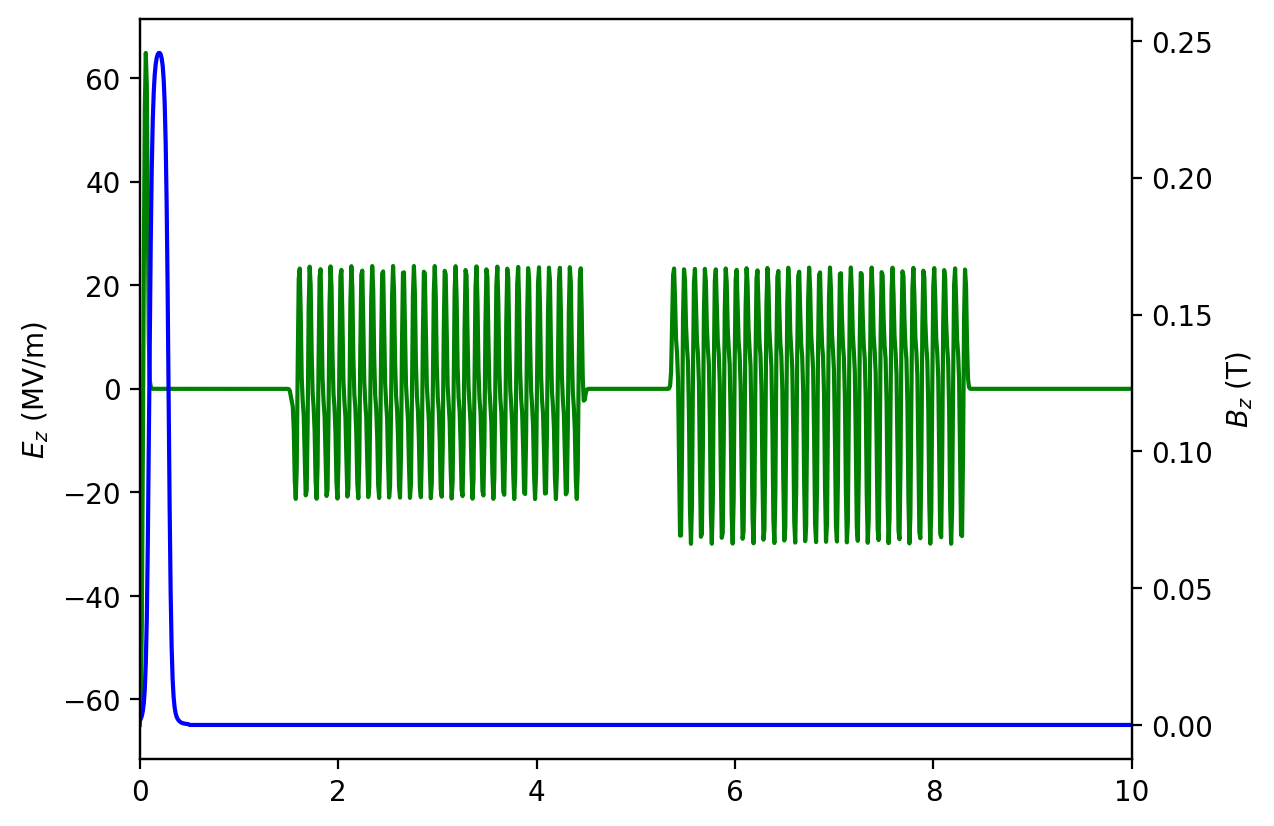

In [6]:
# Fieldmaps can be added to existing axes

from impact.plot import add_fieldmaps_to_axes

fig, ax = plt.subplots()        
add_fieldmaps_to_axes(I, t=1, ax=ax, bounds=(0, 10))   

# Low-level get field

In [7]:
# Get fieldmaps
fmaps = I.fieldmaps

# This shows the field from a single element
ele_field(I.ele['GUN'], z=.1, fmaps=fmaps)

1738690.5187003852

In [8]:
# this gets the total field from all elements in the lattice
lattice_field(I.lattice, z=.3, fmaps=fmaps)

0.0

In [9]:
I.input['fieldmaps'].keys()

dict_keys(['rfdata201', 'rfdata102', 'rfdata4', 'rfdata5', 'rfdata6', 'rfdata7'])

In [10]:
# Period in ps
T = 1 / 2856000000.0
T / 1e-12 # ps

350.140056022409

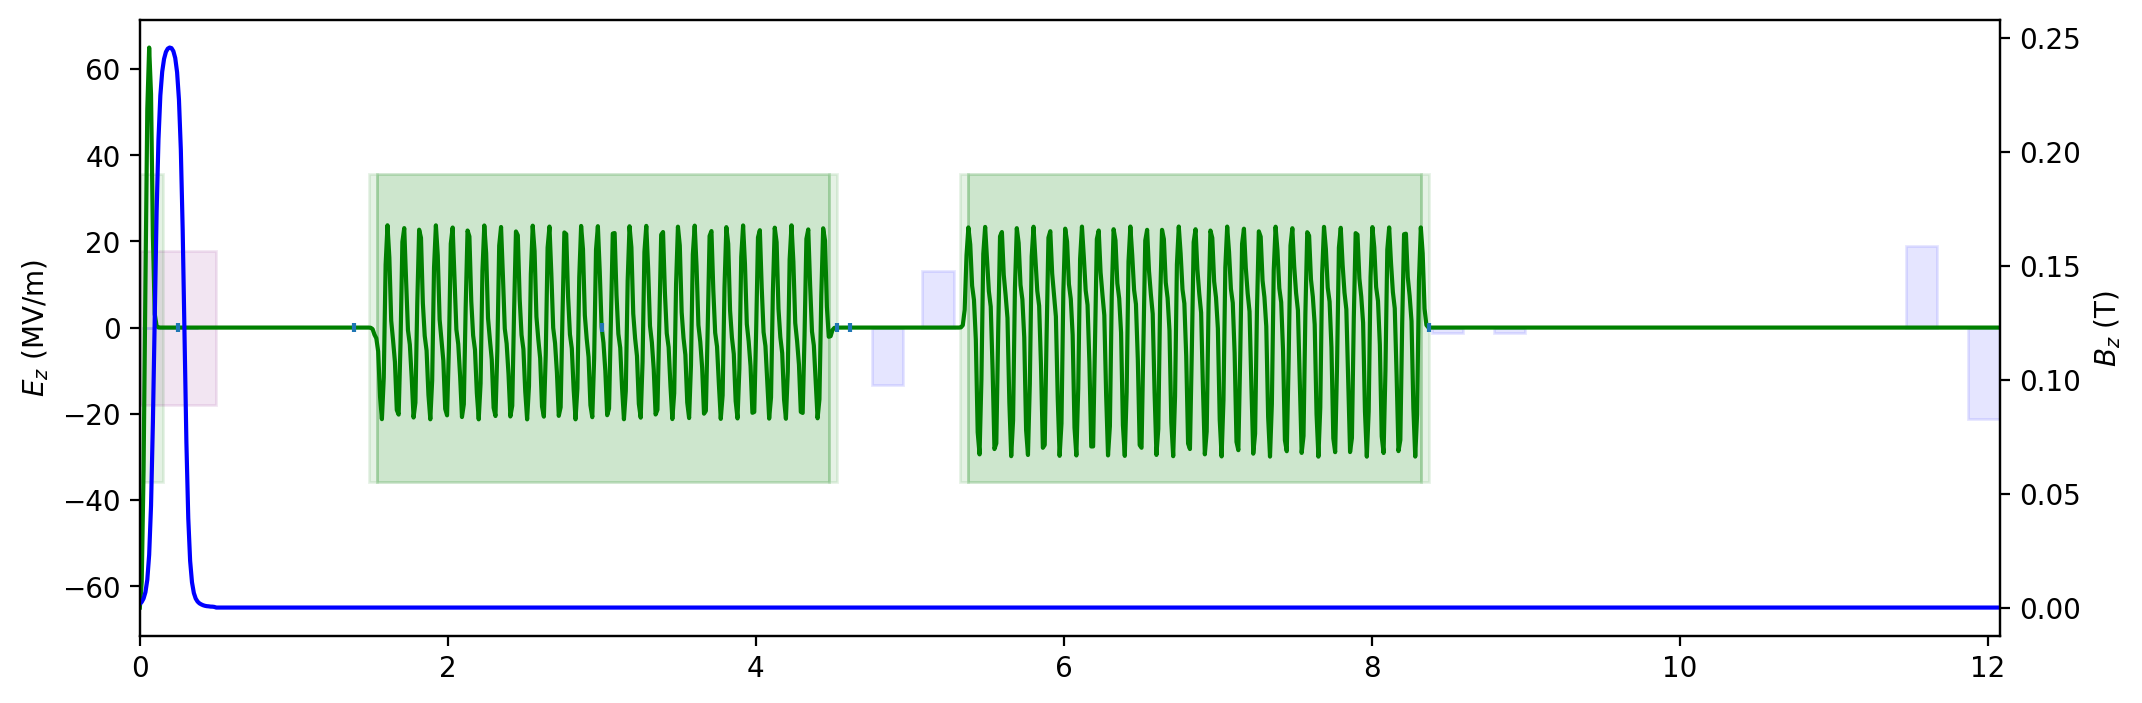

In [11]:
I = Impact(infile)
I.plot(figsize=(12,4), field_t=0)

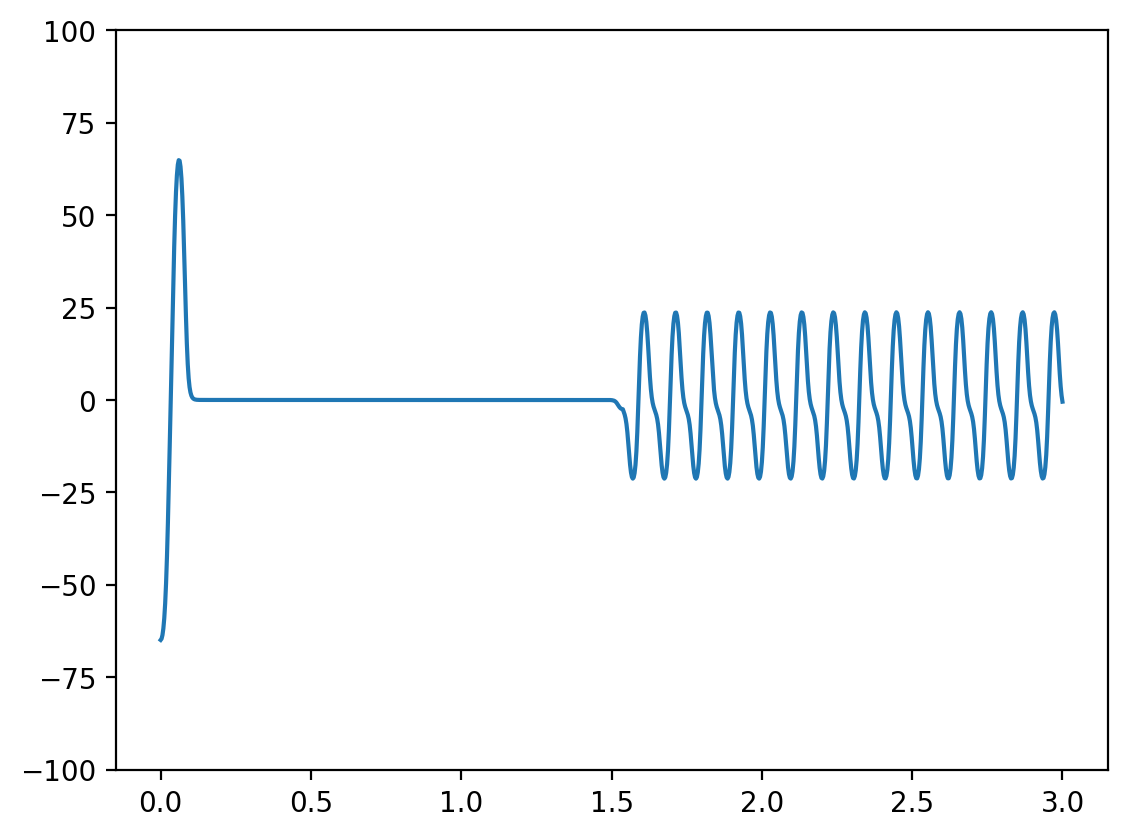

In [12]:
# Make a function to get a field array at a given phase/2pi

zz = np.linspace(0, I.stop, 1000)
def field_at(phi0):
    Ez_at = np.array([I.field(z=z, t=phi0/2856000000.0, 
                                 component='Ez') for z in zz])
    plt.plot(zz, Ez_at/1e6)
    plt.ylim(-100, 100)
    #plt.xlim(2, 2.2)
    
#def field_at(phi0):
#    t=phi0/2856000000.0
#    fig = I.plot(figsize=(12,4), field_t=t, return_figure=True)
#    fig.axes[0].set_ylim(-100,100)
#    fig.axes[1].set_ylim(-0, 0.3)    

field_at(0)

In [13]:
# Visualize the oscillating fields
interact(field_at, phi0=(0, 2, .01))

interactive(children=(FloatSlider(value=1.0, description='phi0', max=2.0, step=0.01), Output()), _dom_classes=â€¦

<function __main__.field_at(phi0)>

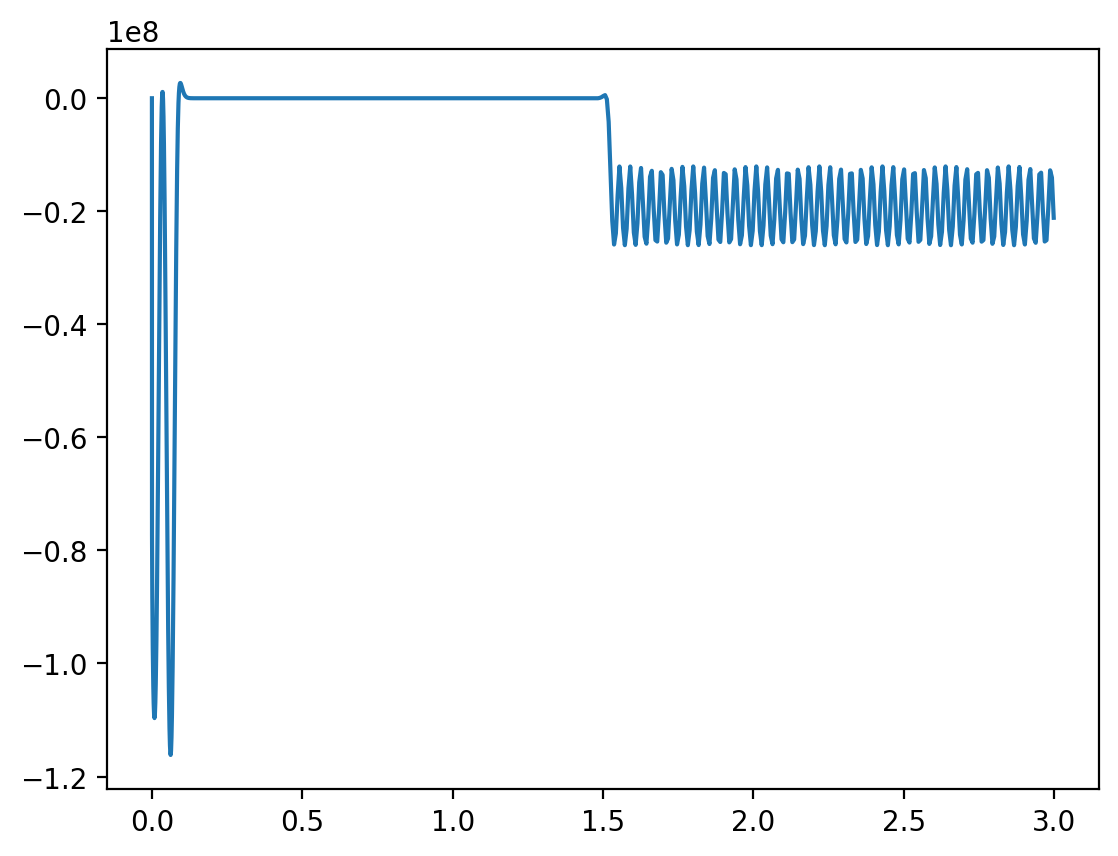

In [14]:
# These are the fields seen by the bunch
I.track1()
zz = I.stat('mean_z')
tt = I.stat('t')

Ez_seen = np.array([lattice_field(I.lattice, z=z, t=t, fmaps=fmaps,
                                 component='Ez') for z, t in zip(zz, tt)])
zz = zz[:len(tt)]
plt.plot(zz, Ez_seen)

In [15]:
# MeV energy gain
-np.trapz(Ez_seen, zz) / 1e6

34.272824268974844

In [16]:
# This is pretty close to the tracked kinetic energy
I.stat('mean_kinetic_energy')[-1]/1e6

34.269711

## Bokeh plotting from the input file

In [17]:
infile = 'templates/lcls_injector/ImpactT.in'
os.path.exists(infile)

dat= parse_impact_input(infile)   
header = dat['header']
lattice = dat['lattice']

In [18]:
layout = layout_plot(lattice)
show(layout)

# Output Plotting

In [19]:
from bokeh.plotting import figure
from bokeh.layouts import column, row
from bokeh.models import ColumnDataSource, Range1d
from impact.parsers import load_many_fort
from impact.parsers import UNITS



In [20]:
opath = 'templates/lcls_injector/output/'
data = load_many_fort(opath, verbose=True)
ds = ColumnDataSource(data)

Loaded fort 30 : Fourth root of the fourth moments of the beam distribution
Loaded fort 25 : RMS Y information
Loaded fort 24 : RMS X information
Loaded fort 26 : RMS Z information
Loaded fort 28 : Load balance and loss diagnostics
Loaded fort 29 : Cube root of third moments of the beam distribution
Loaded fort 18 : Time and energy
Loaded fort 27 : Max amplitude information


In [21]:
def plot1(y_axis, x_axis='mean_z', source=ds):
    yunit = UNITS[y_axis]
    ylabel = y_axis+' ('+yunit+')'
    
    xunit = UNITS[x_axis]
    xlabel = x_axis+' ('+xunit+')'
    p = figure(plot_width=600, plot_height=200, x_axis_label=xlabel, y_axis_label=ylabel)
    p.line( x_axis, y_axis, source=source, color='red')
    return p
show(plot1('norm_emit_x'))

# Stacking plots

This also links the panning, zooming

In [22]:
p1 = plot1('sigma_x')
p2 = plot1('norm_emit_x')
zmax = 2
layout.x_range = Range1d(0,zmax)
p1.x_range = Range1d(0,zmax)

layout.plot_width = p1.plot_width

# Link panning, zooming
layout.x_range = p1.x_range
p2.x_range = p1.x_range

show(
    column(
    p1,
    p2,
    layout))